In [1]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft,fftshift,fftfreq
from scipy.optimize import curve_fit
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.cross_validation import train_test_split

In [4]:
nb_samples = 500

## Load the time domain data set and normalize

In [5]:
#load data
data = []
for i in range(nb_samples):
    data.append(np.genfromtxt("data/" + str(i) + ".txt"))
data = np.asarray(data)

targets = np.genfromtxt("data/labels.txt")

#normalize data to conventional background to min ratio = 1
for i in range(nb_samples):
    data[i,:,1] = ((data[i,:,1]) - min(data[i,:,1]))/(data[i,-1,1] - min(data[i,:,1]))

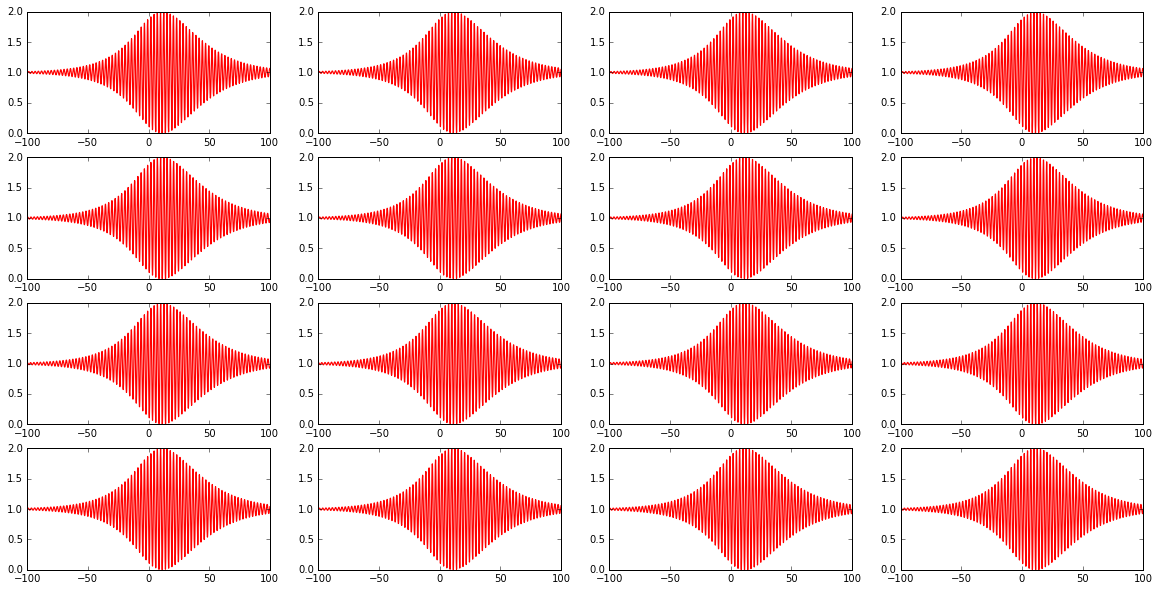

In [6]:
plt.figure(figsize=(20,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(data[i,:,0],data[i,:,1],c='red',lw=1.2)
    plt.xlim(-100,100)
    plt.ylim(0,2)
    #plt.annotate('class=' + str((mode_data["targets"][i]).argmax()), xy = (1,2),color='w',fontsize=16)

## try to perform feature extraction by having a look at the Fourier transformed signals

In [7]:
# fourier transform all data
delta_delay = abs(data[0,0,0]-data[0,1,0])
fdata = []
for d in data:
    fd = fftshift(fft(d[:,1]))
    freqs = np.real(fftshift(fftfreq(fd.size,delta_delay))*2.*np.pi*0.6582)
    fdata.append(np.c_[freqs,fd])
fftdata = np.asarray(fdata)

### as the time domain signal is a 1st order autocorrelation the FFT yields two frequency components
#### w0 component: time independent part
#### w1 component: oscillating with the laser frequency

(2000, 2250)

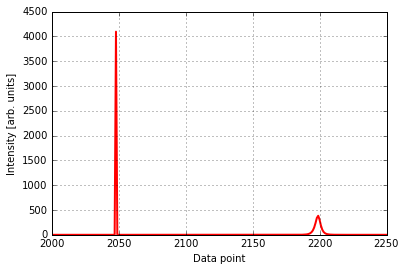

In [8]:
# check tick positions of w0, w1 frequency components
plt.plot(np.abs(fftdata[0,:,1]),c='red',lw=2.)
plt.xlabel("Data point")
plt.ylabel("Intensity [arb. units]")
plt.grid()
plt.xlim(2000,2250)

In [9]:
# define a fit function for the frequency peaks
def fit_function(x,amp,mu,sig):
    return amp*np.exp(-(x-mu)**2/(2.*sig*sig))

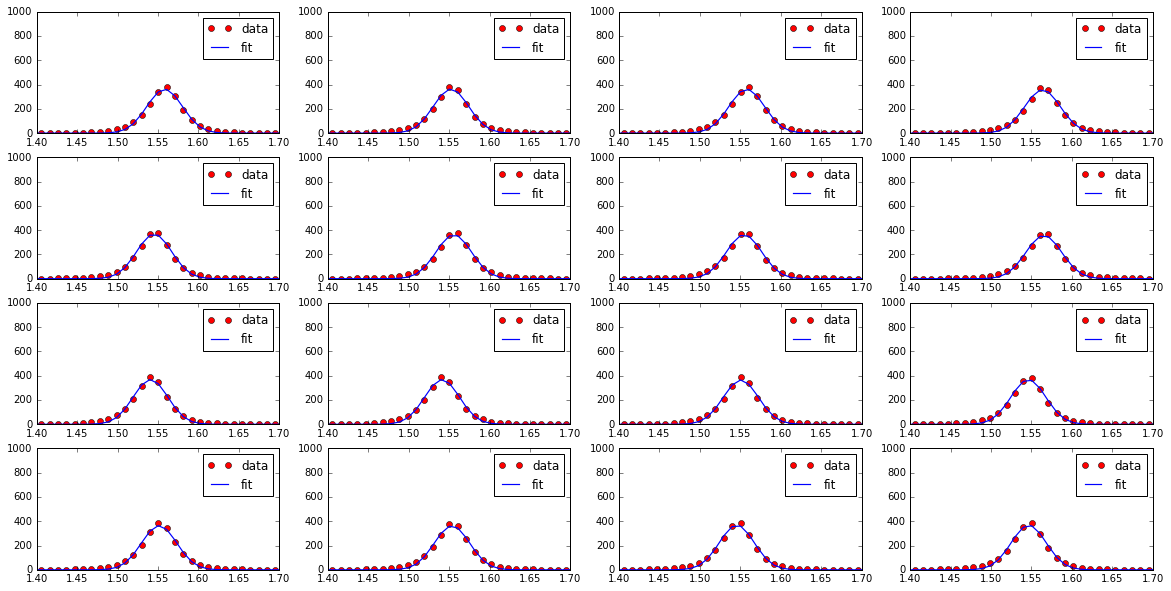

In [10]:
# test and fit the w1 components for the first 16 samples with a Normal distribution
plt.figure(figsize=(20,10))
for i in range(16):
    xval = np.real(fftdata[i,:,0])
    popt, pcov = curve_fit(fit_function, np.real(fftdata[i,2150:2250,0]), np.abs(fftdata[i,2150:2250,1]))
    plt.subplot(4,4,i+1)
    plt.plot(np.real(fftdata[i,:,0]),np.abs(fftdata[i,:,1]),"o",c='red',lw=1.2,label="data")
    plt.plot(xval,fit_function(xval,*popt),c='b',lw=1.2,label="fit")
    plt.legend()
    plt.xlim(1.4,1.7)
    plt.ylim(0,1000)

## Fit the whole batch for w1

In [11]:
features = []
for i in range(nb_samples):
    params, cov = curve_fit(fit_function, np.real(fftdata[i,2150:2250,0]), np.abs(fftdata[i,2150:2250,1]))
    
    # add amp, spectral position and width to feature list
    features.append([params[0],params[1],np.abs(params[2])])
features = np.asarray(features)
scaled_features = scale(features)

### check if there are already patterns

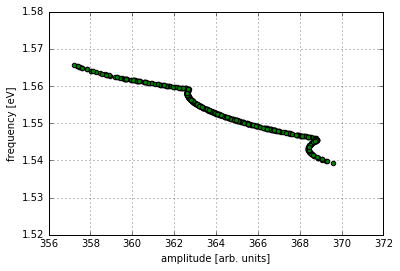

In [12]:
plt.scatter(features[:,0],features[:,1],c="g")
plt.grid()
plt.xlabel("amplitude [arb. units]")
plt.ylabel("frequency [eV]")

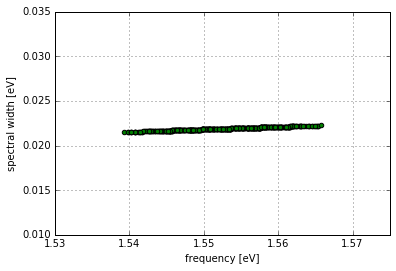

In [13]:
plt.scatter(features[:,1],features[:,2],c="g")
plt.ylabel("spectral width [eV]")
plt.xlabel("frequency [eV]")
plt.grid()

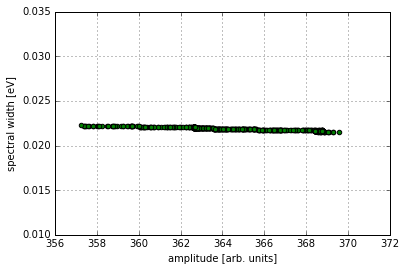

In [14]:
plt.scatter(features[:,0],features[:,2],c="g")
plt.ylabel("spectral width [eV]")
plt.xlabel("amplitude [arb. units]")
plt.grid()

## Perform K-means clustering to see if the data falls into two catergories -> positive and negative chirp 

### Principal Component Analysis

In [15]:
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

In [16]:
def plot_clusters(data,labels):
    fig = plt.figure(figsize=(6, 6))
    ax = Axes3D(fig, elev=14, azim=130)
    ax.scatter(data[:,0], data[:,1], data[:,2],c=labels.astype(np.float))
    for n in range(max(labels)+1):
        text = "class " + str(n)
        ax.text3D(data[labels==n,0].mean(), data[labels==n,1].mean(), data[labels==n,2].mean(),text)

    ax.set_xlabel('amplitude [arb. units]',size=12)
    ax.set_ylabel('frequency [eV]', size=12)
    ax.set_zlabel('spectral width [eV]', size=12)

def fit_kmeans_clusters(data,name,clusters=2): 
    estimator = KMeans(n_clusters=clusters)
    estimator.fit(data)
    labels = estimator.labels_
    print('%5s   %5i     %.3f    %.3f   %.3f   %.3f   %.3f   %.3f'
      % (name, i,              
         metrics.homogeneity_score(labels, estimator.labels_),
         metrics.completeness_score(labels, estimator.labels_),
         metrics.v_measure_score(labels, estimator.labels_),
         metrics.adjusted_rand_score(labels, estimator.labels_),
         metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_, metric='euclidean',sample_size=nb_samples)))
    return labels
    

### PCA vs raw data

In [17]:
print('clusters   homo    compl    vm      ari     mi      sil')
print('-'*60)
l1 = fit_kmeans_clusters(data=scaled_features, name="raw");
l2 = fit_kmeans_clusters(data=pca_features, name="PCA");

clusters   homo    compl    vm      ari     mi      sil
------------------------------------------------------------
  raw     499     1.000    1.000   1.000   1.000   1.000   0.605
  PCA     499     1.000    1.000   1.000   1.000   1.000   0.639


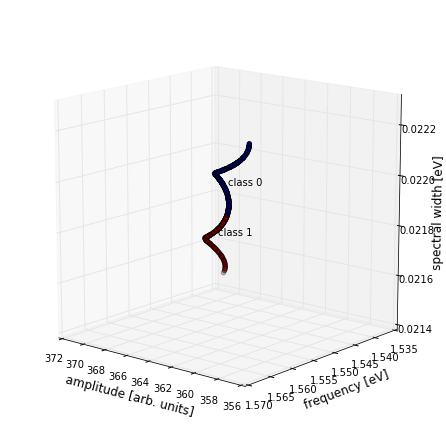

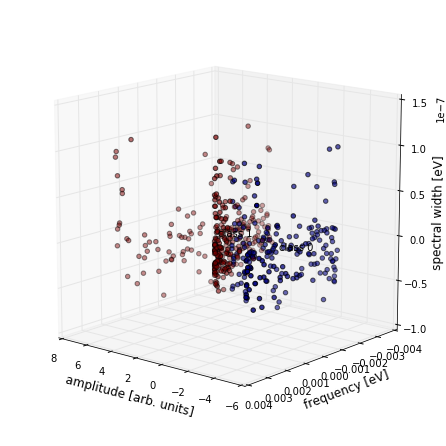

In [18]:
plot_clusters(features,l1)
plot_clusters(pca_features,l2)

### Plot true clusters

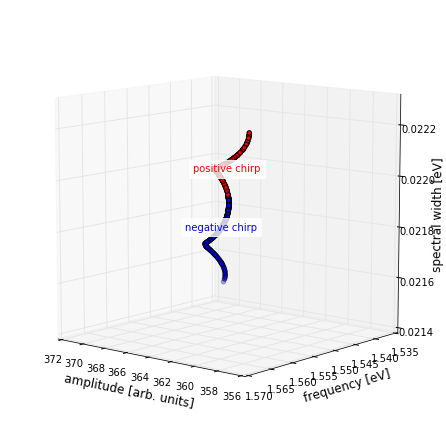

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, elev=10, azim=130)
ax.scatter(features[targets==1,0], features[targets==1,1], features[targets==1,2],c="r")
ax.scatter(features[targets==0,0], features[targets==0,1], features[targets==0,2],c="b")
ax.text3D(features[targets==0,0].mean(), features[targets==0,1].mean(), features[targets==0,2].mean(), "negative chirp",color="b",
              horizontalalignment='center',
              bbox=dict(alpha=.8, edgecolor='w', facecolor='w'))
ax.text3D(features[targets==1,0].mean(), features[targets==1,1].mean(), features[targets==1,2].mean(), "positive chirp",color="r",
              horizontalalignment='center',
              bbox=dict(alpha=.8, edgecolor='w', facecolor='w'))
ax.set_xlabel('amplitude [arb. units]',size=12)
ax.set_ylabel('frequency [eV]',size=12)
ax.set_zlabel('spectral width [eV]',size=12)

## Support Vector Machine Classification

### generate train and test data

In [20]:
svm_data_raw = {'data':features,'targets':l1}
svm_data_pca = {'data':features,'targets':l2}

In [21]:
input_train, input_test, output_train, output_test = train_test_split(svm_data_raw['data'], svm_data_raw['targets'],test_size = 0.3)


In [22]:
# test different kernel methods
reg_param = 1.
svc = svm.SVC(kernel='linear', C=reg_param).fit(input_train, output_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.5, C=reg_param).fit(input_train, output_train)
poly_svc = svm.SVC(kernel='poly', degree=5, C=reg_param).fit(input_train, output_train)

In [23]:
# predictions
pred_svc = svc.predict(input_test)
pred_rbf = rbf_svc.predict(input_test)
pred_poly = poly_svc.predict(input_test)

In [24]:
for data in [pred_svc,pred_rbf,pred_poly]:
    print("accuracy = " + str(metrics.accuracy_score(output_test,data)*100) + "%" )

accuracy = 99.3333333333%
accuracy = 99.3333333333%
accuracy = 100.0%
